In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy.orm import Session
import scikit_posthocs as sp

from april.database import get_engine
from april.fs import PLOT_DIR
from april.utils import microsoft_colors, prettify_dataframe, cd_plot, get_cd
from april.enums import Base, Strategy, Heuristic

sns.set_style('white')
pd.set_option('display.max_rows', 50)
%config InlineBackend.figure_format = 'retina'

In [54]:
out_dir = PLOT_DIR / 'isj-2019'
eval_file = out_dir / 'eval.pkl'

### Helper objects

In [55]:
synth_datasets = ['paper', 'p2p', 'small', 'medium', 'large', 'huge', 'gigantic', 'wide']
bpic_datasets = ['bpic12', 'bpic13', 'bpic15', 'bpic17']
anonymous_datasets = ['real']
datasets = synth_datasets + bpic_datasets + anonymous_datasets
dataset_types = ['Synthetic', 'Real-life']

binet_ads = ["BINetv1", "BINetv2", "BINetv3"]
nn_ads = ["dae"] + binet_ads
h_ads = nn_ads + [ "Likelihood+", "t-STIDE+", "Naive+"]
d_ads = ["naive", "sampling", "Likelihood", "OC-SVM"]
ads = h_ads + d_ads
ads = ['dae', 'naive', 'random', 'sampling']
heuristics = [r'$best$', r'$default$', r'$elbow_\downarrow$', r'$elbow_\uparrow$', 
              r'$lp_\leftarrow$', r'$lp_\leftrightarrow$', r'$lp_\rightarrow$']
print(ads)

['dae', 'naive', 'random', 'sampling']


## Retrieve evaluations from pickle file

In [56]:
evaluation = pd.read_pickle(eval_file)

In [57]:
print(evaluation["ad"].unique())

['dae' 'naive' 'random' 'sampling']


### Add identifier for BPIC datasets and filter for ADs

In [58]:
evaluation = evaluation.query(f'ad in {ads} and label == "Anomaly"')
display(evaluation.head())

,file_name,date,hyperparameters,training_duration,training_host,ad,dataset_name,process_model,noise,dataset_id,axis,base,heuristic,strategy,label,attribute_name,perspective,precision,recall,f1
1,medium-0.3-1_dae_20250319-131452.729609.keras,2025-03-19 13:15:11.812268,None,None,None,dae,medium-0.3-1,medium,0.3,1,0,scores,best,single,Anomaly,name,Control Flow,0.669202,0.987971,0.797927
3,medium-0.3-1_dae_20250319-131452.729609.keras,2025-03-19 13:15:11.812268,None,None,None,dae,medium-0.3-1,medium,0.3,1,0,scores,best,single,Anomaly,user,Data,0.000000,0.000000,0.000000
5,medium-0.3-1_dae_20250319-131452.729609.keras,2025-03-19 13:15:11.812268,None,None,None,dae,medium-0.3-1,medium,0.3,1,1,scores,best,single,Anomaly,name,Control Flow,0.384695,0.764318,0.511795
7,medium-0.3-1_dae_20250319-131452.729609.keras,2025-03-19 13:15:11.812268,None,None,None,dae,medium-0.3-1,medium,0.3,1,1,scores,best,single,Anomaly,user,Data,0.000000,0.000000,0.000000
9,medium-0.3-1_dae_20250319-131452.729609.keras,2025-03-19 13:15:11.812268,None,None,None,dae,medium-0.3-1,medium,0.3,1,2,scores,best,single,Anomaly,name,Control Flow,0.384695,0.764318,0.511795


In [59]:
evaluation['perspective-label'] = evaluation['perspective'] + '-' + evaluation['label']
evaluation['attribute_name-label'] = evaluation['attribute_name'] + '-' + evaluation['label']
evaluation['dataset_type'] = 'Synthetic'
evaluation.loc[evaluation['process_model'].str.contains('bpic'), 'dataset_type'] = 'Real-life'
evaluation.loc[evaluation['process_model'].str.contains('real'), 'dataset_type'] = 'Real-life'

### Filter for best strategy

In `5.1 Best Strategy.ipynb` we find that $\tau_0$ and $\tau_a$ seem to work best overall. Intuatively it makes sense to set a threshold $\tau$ per attribute, hence we select $\tau_a$ whereever applicable.

In [60]:
_filtered_evaluation = evaluation.query(f'ad in {h_ads} and (strategy == "{Strategy.ATTRIBUTE}"'
                                       f' or (strategy == "{Strategy.SINGLE}" and process_model == "bpic12")'
                                       f' or (strategy == "{Strategy.SINGLE}" and ad == "Naive+")) or ad in {d_ads}')

### Filter for best heuristic

In `5.2 Best Heuristic.ipynb` we find that $lp_\rightarrow$ works best overall, aparat from DAE. For DAE we use $elbow_\uparrow$. For all default methods we use $default$.

In [61]:
filtered_evaluation = _filtered_evaluation.query(f'heuristic == "{Heuristic.DEFAULT}"'
                                                 f' or (heuristic == "{Heuristic.LP_MEAN}" and ad != "dae")'
                                                 f' or (heuristic == "{Heuristic.ELBOW_UP}" and ad == "dae")')

## Plot featured in paper (Figure 10)

In [65]:
df = filtered_evaluation.query('axis == 2')  # We give results on attribute level
df = prettify_dataframe(df)
print(df.groupby(['ad', 'file_name', 'dataset_type', 'dataset_name', 'perspective'])[['precision', 'recall', 'f1']])

                                              file_name  \
213       medium-0.3-1_dae_20250319-131452.729609.keras   
215       medium-0.3-1_dae_20250319-131452.729609.keras   
297     medium-0.3-1_naive_20250319-131450.236340.keras   
299     medium-0.3-1_naive_20250319-131450.236340.keras   
321   medium-0.3-1_sampling_20250319-131450.964413.k...   
...                                                 ...   
2715     small-0.3-2_naive_20250319-131450.874247.keras   
2717     small-0.3-2_naive_20250319-131450.874247.keras   
2749  small-0.3-2_sampling_20250319-131452.466047.keras   
2751  small-0.3-2_sampling_20250319-131452.466047.keras   
2753  small-0.3-2_sampling_20250319-131452.466047.keras   

                           date hyperparameters training_duration  \
213  2025-03-19 13:15:11.812268            None              None   
215  2025-03-19 13:15:11.812268            None              None   
297  2025-03-19 13:14:50.334753            None              None   
299  2025-03-19

/tmp/ipykernel_22580/3061828762.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack(1).stack(1).reset_index()
/tmp/ipykernel_22580/3061828762.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack(1).stack(1).reset_index()
/mnt/d/keras/lib/python3.9/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)


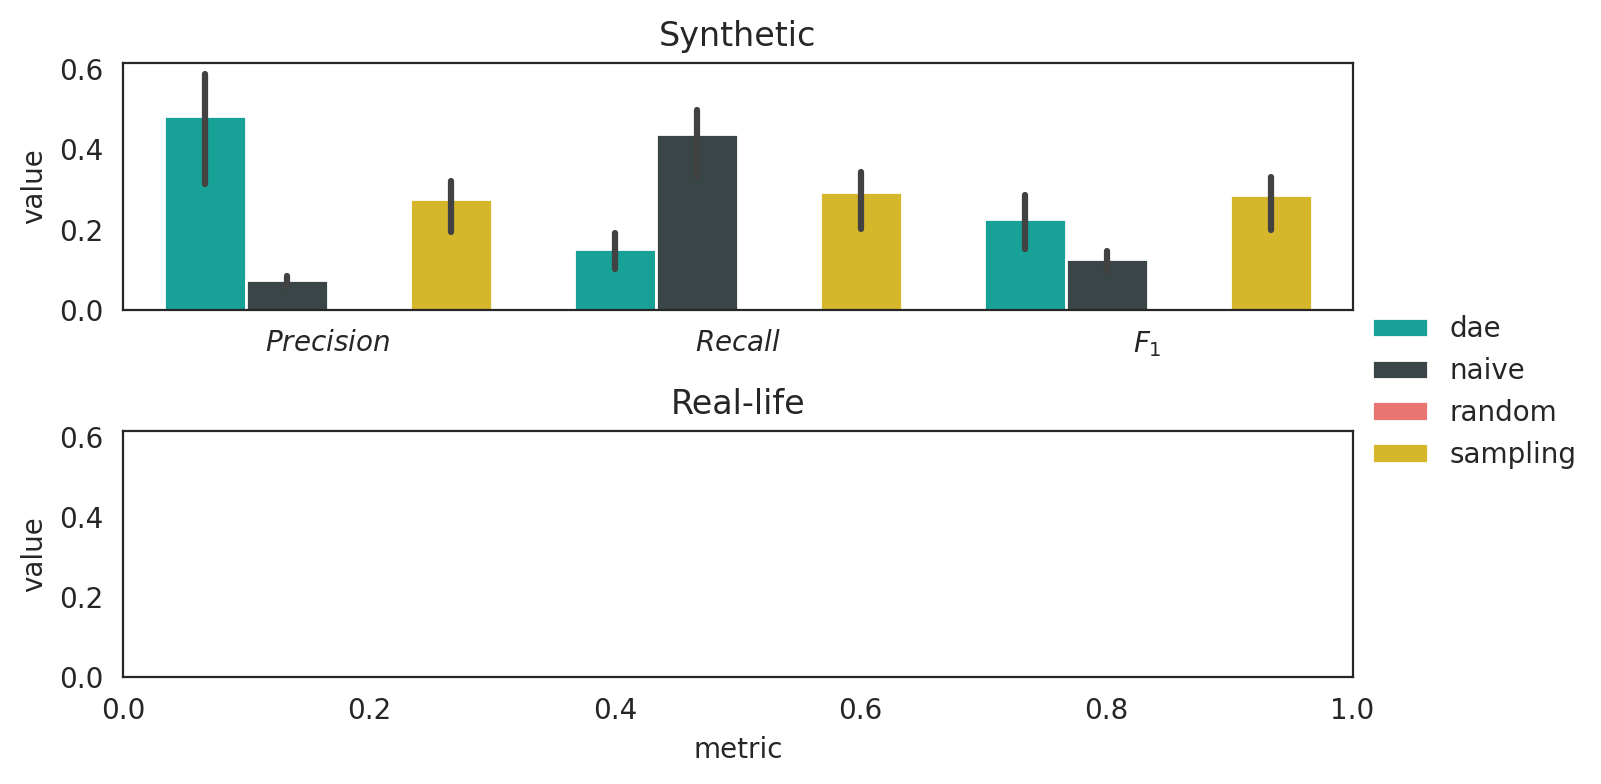

In [ ]:
# Set up dataframe
df = filtered_evaluation.query('axis == 2')  # We give results on attribute level
df = prettify_dataframe(df)
print(df)
# We first have to average for the two perspectives (to always weigh CF and Data 1 to 1), then we can average over all runs and datasets
df = df.groupby(['ad', 'file_name', 'dataset_type', 'dataset_name', 'perspective'])[['precision', 'recall', 'f1']].mean().reset_index()
df = df.groupby(['ad', 'file_name', 'dataset_type', 'dataset_name'])[['precision', 'recall', 'f1']].mean().reset_index()
df['f1'] = 2 * df['recall'] * df['precision'] / (df['recall'] + df['precision'])  # We recalculate the F1 score based on the new averaged P and R values

# We want to penalize DAE for running out of memory on some of the BPIC datasets, hence we set the F1 score to zero where DAE has NaN values
df = pd.pivot_table(df, index=['ad'], columns=['dataset_type', 'dataset_name'], values=['precision', 'recall', 'f1'])
df = df.fillna(0)
df = df.stack(1).stack(1).reset_index()

# Plot
df = df.melt(id_vars=['ad', 'dataset_type', 'dataset_name'], value_vars=['precision', 'recall', 'f1'], var_name='metric')
df = df.replace('f1', r'$F_1$').replace('precision', r'$Precision$').replace('recall', r'$Recall$')

g = sns.FacetGrid(data=df, row='dataset_type', sharex=False, sharey=True, despine=False, height=2, aspect=3.5, row_order=dataset_types)
g = g.map_dataframe(sns.barplot, x='metric', y='value', hue='ad', palette=microsoft_colors, hue_order=ads, order=[r'$Precision$', r'$Recall$', r'$F_1$'])
g = g.add_legend()

g.axes.flat[0].set(title='Synthetic')
g.axes.flat[1].set(title='Real-life')

g.savefig(str(out_dir / 'eval_overall.pdf'))

## Significance Test (Fig. 11)

Pairwise significance shown in CD diagram (Demsar 2006).

/tmp/ipykernel_22580/2236514482.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack(1).reset_index()
/tmp/ipykernel_22580/2236514482.py:23: FutureWarning: The provided callable <function mean at 0x7f149970a1f0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  ranks = df.groupby(['ad'])['rank'].agg(np.mean).dropna().round(2)


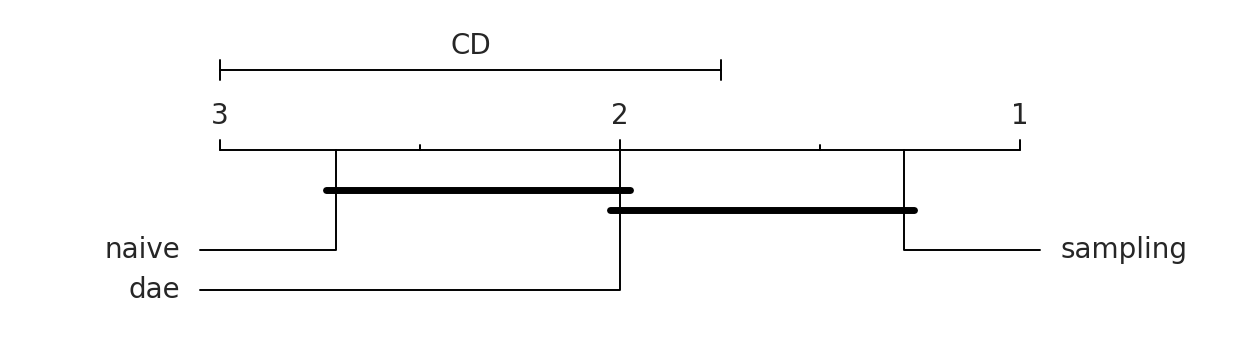

In [ ]:
df = filtered_evaluation.query('axis == 2 and dataset_type == "Synthetic"')
df = prettify_dataframe(df)

# We first have to average for the two perspectives (to always weigh CF and Data 1 to 1), then we can average over all runs and datasets
df = df.groupby(['ad', 'file_name', 'dataset_type', 'dataset_name', 'perspective'])[['precision', 'recall', 'f1']].mean().reset_index()
df = df.groupby(['ad', 'dataset_type', 'dataset_name'])[['precision', 'recall', 'f1']].mean().reset_index()
df['f1'] = 2 * df['recall'] * df['precision'] / (df['recall'] + df['precision'])  # We recalculate the F1 score based on the new averaged P and R values
# df['f1'] = df['f1'].fillna(0)

# We want to penalize DAE for running out of memory on some of the BPIC datasets, hence we set the F1 score to zero where DAE has NaN values
df = pd.pivot_table(df, index=['ad', 'dataset_type'], columns=['dataset_name'], values=['f1'])
df = df.fillna(0)
df = df.stack(1).reset_index()

# Rank by F1 score
df['rank'] = df.groupby(['dataset_name'])['f1'].rank(ascending=False)

k = len(df['ad'].unique())
n = len(df) / k
alpha = 0.05
cd = get_cd(k, n, alpha)  # Critical difference for k groups, n blocks

ranks = df.groupby(['ad'])['rank'].agg(np.mean).dropna().round(2)
fig = cd_plot(ranks, cd=cd, reverse=True)
fig.savefig(str(out_dir / 'significance.pdf'))

Pairwise significance using Nemenyi-Friedman.

In [ ]:
nemenyi_df = df.groupby(['ad', 'dataset_name'])[['rank']].mean().dropna().reset_index()
pc = sp.posthoc_nemenyi_friedman(nemenyi_df, y_col='rank', group_col='ad', block_col='dataset_name', melted=True)
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
fig = sp.sign_plot(pc, **heatmap_args)

ValueError: `block_col` contains duplicated entries, `block_id_col` should be explicitly specified

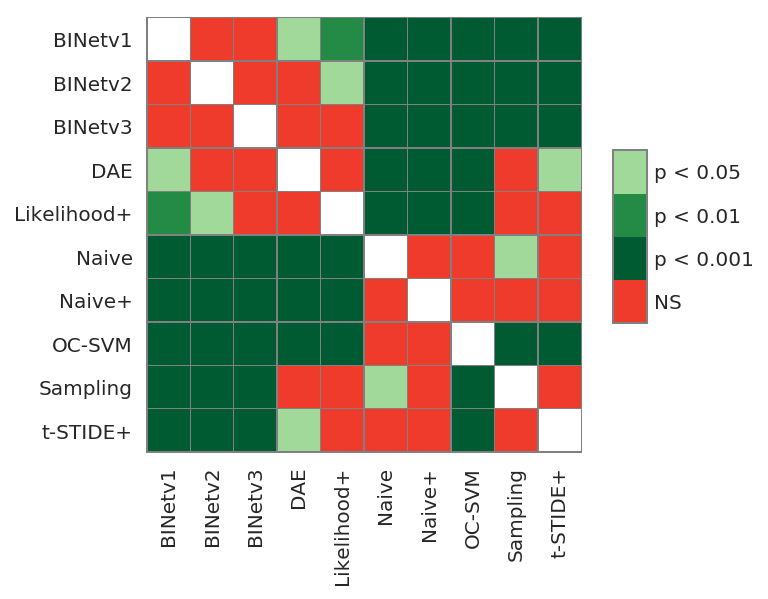

In [ ]:
dunn_df = df.groupby(['ad', 'dataset_name'])['rank'].mean().dropna().reset_index()
pc = sp.posthoc_dunn(dunn_df, val_col='rank', group_col='ad', p_adjust='bonferroni')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
fig = sp.sign_plot(pc, **heatmap_args)

## Result table featured in the paper (Table 2)

In [63]:
df = filtered_evaluation.query('axis in [0, 2]')
df = prettify_dataframe(df)
df = df.groupby(['axis', 'process_model', 'dataset_name', 'ad', 'file_name', 'perspective'])[['precision', 'recall', 'f1']].mean().reset_index()
df = df.groupby(['axis', 'process_model', 'dataset_name', 'ad', 'file_name'])[['precision', 'recall', 'f1']].mean().reset_index()
df['f1'] = 2 * df['recall'] * df['precision'] / (df['recall'] + df['precision'])

df = pd.pivot_table(df, index=['axis', 'ad'], columns=['process_model', 'dataset_name'], values=['precision', 'recall', 'f1'])
df = df.fillna(0)
df = df.stack(1).stack(1).reset_index()
df.to_excel(str(out_dir / 'table.xlsx'), index=False)

df = pd.pivot_table(df, index=['axis', 'ad'], columns=['process_model'], values=['f1'], aggfunc=np.mean)
df.round(2)

/tmp/ipykernel_22580/3255890081.py:9: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack(1).stack(1).reset_index()
/tmp/ipykernel_22580/3255890081.py:9: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack(1).stack(1).reset_index()
/tmp/ipykernel_22580/3255890081.py:12: FutureWarning: The provided callable <function mean at 0x7f149970a1f0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = pd.pivot_table(df, index=['axis', 'a

f1                  
process_model      Medium   P2P Paper Small
axis      ad                               
Attribute dae        0.23  0.23  0.05  0.25
          naive      0.13  0.15  0.04  0.14
          sampling   0.32  0.33  0.03  0.33
Case      dae        0.37  0.54  0.27  0.52
          naive      0.40  0.48  0.13  0.48
          sampling   0.47  0.49  0.12  0.49